# GFP for sentence - epoching on sentence end and go from there

In [1]:
# Homemade imports
from dataset import get_path, get_subjects, epoch_runs
from plot import plot_subject

# General imports
import numpy as np
import mne
import hydra
from omegaconf import DictConfig


In [2]:
path = get_path("LPP_read")
subjects = get_subjects(path)
RUN = 1
task = "read"
subject = subjects[4]
baseline_min = -4.0
baseline_max = 0.5

In [3]:
epochs = epoch_runs(subject, RUN, task, path, baseline_min,baseline_max, epoch_on='sentence')

.Running the script on RAW data:
run 01, subject: 5
Opening raw data file /home/co/data/BIDS_lecture/sub-5/ses-01/meg/sub-5_ses-01_task-read_run-01_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 89000 ... 554999 =     89.000 ...   554.999 secs
Ready.
Reading events from /home/co/data/BIDS

/home/co/workspace_LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:88: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/home/co/workspace_LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:88: RuntimeWarning: Omitted 128 annotation(s) that were outside data range.
  raw = mne_bids.read_raw_bids(bids_path)
/home/co/workspace_LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:88: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne_bids.read_raw_bids(bids_path)
/home/co/workspace_LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:88: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


1468 events found
Event IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    4.4s finished


Adding metadata with 13 columns
18 matching events found
Setting baseline interval to [-4.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 18 events and 4501 original time points (prior to decimation) ...
0 bad epochs dropped


/home/co/workspace_LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:165: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=20 parameter will result in a sampling frequency of 50.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(


Adding metadata with 14 columns
18 matching events found
Applying baseline correction (mode: mean)


/home/co/workspace_LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:243: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(epochs)


In [12]:
epochs.metadata

,level_0,index,Unnamed: 0,word,onset,duration,trial_type,start,condition,n_closing,is_last_word,pos,content_word,label,kind
0,35,35,35,dessin,12.2,0.25,"{'kind': 'word', 'word': 'dessin'}",101.820,sentence,5,True,NC,True,run_1,word
1,251,255,255,explications,85.2,0.25,"{'kind': 'word', 'word': 'explications'}",167.501,sentence,11,True,NC,True,run_1,word
2,302,306,306,nuit,103.0,0.25,"{'kind': 'word', 'word': 'nuit'}",183.534,sentence,9,True,NC,True,run_1,word
3,341,345,345,opinion,116.7,0.25,"{'kind': 'word', 'word': 'opinion'}",195.884,sentence,3,True,NC,True,run_1,word
4,425,431,431,raisonnable,145.5,0.25,"{'kind': 'word', 'word': 'raisonnable'}",221.800,sentence,9,True,ADJ,True,run_1,word
5,497,503,503,jours,171.6,0.25,"{'kind': 'word', 'word': 'jours'}",245.266,sentence,10,True,NC,True,run_1,word
6,552,559,559,mouton,190.9,0.25,"{'kind': 'word', 'word': 'mouton'}",262.633,sentence,4,True,NC,True,run_1,word
7,652,660,660,ouverts,226.2,0.25,"{'kind': 'word', 'word': 'ouverts'}",294.398,sentence,11,True,ADJ,True,run_1,word
8,729,737,737,dis,251.8,0.25,"{'kind': 'word', 'word': 'dis'}",317.448,sentence,6,True,V,True,run_1,word
9,1015,1040,1040,mouton,357.7,0.25,"{'kind': 'word', 'word': 'mouton'}",412.779,sentence,7,True,NC,True,run_1,word


In [30]:
meta["end"] = [print(row['start']) for i, row in epochs.metadata.iterrows()]

101.82
167.501
183.534
195.884
221.8
245.266
262.633
294.398
317.448
412.779
415.812
428.496
451.278
462.795
464.061
499.51
518.493
537.843


NameError: name 'meta' is not defined

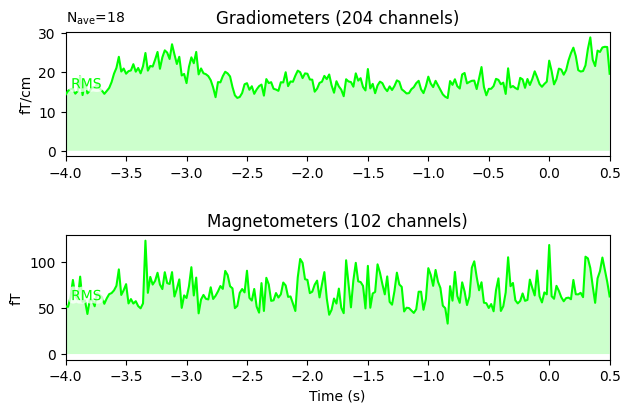

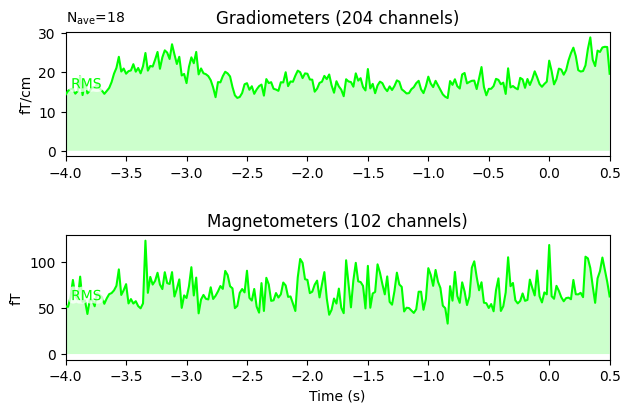

In [13]:
evo = epochs.average(method="median")
evo.plot(gfp='only')

In [16]:
epochs.events

array([[101820,      1,      1],
       [167501,      1,      1],
       [183534,      1,      1],
       [195884,      1,      1],
       [221800,      1,      1],
       [245266,      1,      1],
       [262633,      1,      1],
       [294398,      1,      1],
       [317448,      1,      1],
       [412779,      1,      1],
       [415812,      1,      1],
       [428496,      1,      1],
       [451278,      1,      1],
       [462795,      1,      1],
       [464061,      1,      1],
       [499510,      1,      1],
       [518493,      1,      1],
       [537843,      1,      1]])

In [4]:
def epochs_(epochs, column, value):
    meta  = epochs.metadata
    subset = meta[meta[column]==value].level_0
    return epochs[subset]


In [5]:
epochs.metadata['n_closing'][:50]

0      5
1     11
2      9
3      3
4      9
5     10
6      4
7     11
8      6
9      7
10     5
11     6
12     5
13     4
14     3
15     9
16     7
17     5
Name: n_closing, dtype: int64

In [6]:
epochs_(epochs,'is_last_word',True)

IndexError: index 35 is out of bounds for axis 0 with size 18

In [ ]:
import matplotlib.pyplot as plt
# Build a 3x2 plot, with for each condition (sentence, word, constituent), and for (start, end),
# the ERP associated
cond = {'sentence': {'column':'is_last_word','target':True},
        'word': {'column':'kind','target':'word'},
        'constituent': {'column':'n_closing','target':2}}

cases = {'start', 'end'}

i = 1
for condi in cond:
    for case in cases:
        ep = epochs_(epochs, cond[condi]['column'], cond[condi]['target'])
        ax = fig.add_subplot(3, 2, i)
        #ep.average().plot(gfp='only')
        evo = ep.average(method="median")
        evo.plot(spatial_colors=True)
        i = i + 1
        ax.set_title(f'Plot {cond}')


plt.show()


In [ ]:
epochs_4 = epochs_(epochs, 'n_closing', 4)

In [ ]:
epochs_4.average().plot(gfp='only')

In [ ]:
evo = epochs.average(method="median")
evo.plot(spatial_colors=True)

In [ ]:
metadata_subset

In [ ]:
from mne import Epochs

class CustomEpochs(Epochs):

    def __getitem__(self, key):
        # Parse the key into metadata field name and value
        field, value = key.split('==')
        field = field.strip()
        value = value.strip()

        # Get the indices of the epochs that match the metadata query
        indices = [i for i, metadata in enumerate(self.metadata[field]) if metadata == value]

        # Return a new Epochs object containing only the matching epochs
        return self.__class__(self._data[indices], self.events[indices], self.event_id,
                              tmin=self.tmin, tmax=self.tmax, baseline=self.baseline,
                              metadata=self.metadata.iloc[indices], info=self.info)



In [ ]:
custom_epochs = CustomEpochs(epochs, epochs.events, "1", -0.2, 0.8, epochs.baseline, epochs.metadata)

# Get all epochs where the 'kind' metadata field is 'word':
word_epochs = custom_epochs['kind==word']

In [ ]:
custom_epochs['kind=="word"']

In [ ]:
# epoch
def mne_events(meta):
    events = np.ones((len(meta), 3), dtype=int)
    events[:, 0] = meta.start*raw.info['sfreq']
    return dict(events=events, metadata=meta.reset_index())

epochs = mne.Epochs(raw, **mne_events(meta), decim=20, tmin=-.2, tmax=1.5, preload=True)
epochs = epochs['kind=="word"']

In [ ]:
from dataset import get_path, get_subjects, epoch_data, epoch_runs
from utils import (
    decod,
    correlate,
    match_list,
    create_target,
    analysis,
    save_decoding_results,
)
from plot import plot_subject
import mne_bids
from pathlib import Path
import pandas as pd
import numpy as np
import mne
import spacy
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import RidgeCV
from wordfreq import zipf_frequency
from Levenshtein import editops
import matplotlib.pyplot as plt

In [ ]:
path = get_path("LPP_read")
subjects = get_subjects(path)
RUN = 9
task = "read"
subject = subjects[4]

In [ ]:
epochs = epoch_runs(subject, RUN, task, path)

In [ ]:
(epochs.metadata).dtype

In [ ]:
epochs.load_data()
epochs = epochs['kind=="word"']
epochs["content_word == False"]